# The worst US States for getting stuck in traffic from accidents and construction.

I have long been interested in the experiences of driving across the United States. Almost everyone I have met in the United States has their own anecdotes about how bad certain states are for drivers. 

- "There is so much construction in Pennsylvania!"
- "Arizona drivers are reckless!"
- "Jersey drivers are THE WORST."

I decided to pull data that are available to me for a slightly tongue-in-cheek exercise to determine which US states actually are most unpleasant for drivers. There are several major factors that come to mind when considering "unpleasantness for drivers":

1. Traffic
2. Construction (related to traffic)
3. Accidents (related to traffic)
4. Difficulty of driving (rough roads, poorly signed roads, single-lane roads)

Traffic is the single biggest item. I don't think anyone would argue that commuting by car in San Francisco or New York City is pleasant. However, this is difficult to quantify across the entire US - in addition to requiring some measure of the speed of traffic flow, we would also need average trip lengths across the country to make a meaningful comparison. Additionally, when browsing Kaggle and the internet in general, I was unable to find a reaonably accessible dataset that would allow me to quantify the concept of "traffic."

I think most people would agree, though, that the presence of road construction and accidents both contribute to negative driving experiences. Especially when considering long distance driving, where a driver may cross multiple state boundaries, accident and construction frequency may be a better indicator of driving experiences than commuting traffic around major metropolitan areas. Personally, I have had several jobs that regularly required me to drive several hundred miles regularly, and I developed plenty of anecdotal assumptions while doing so (Ohio is OK, Pennsylvania is bad for construction, DC is bad for accidents, etc.). Lastly, I am interested in comparing US states against eachother; what is it like for a driver who is "just passing through?" I also think there is some fun to be had in a sports-like fashion by using states as the unit of comparison. I have a major grudge against Pennsylvania for the amount of traffic I have incurred on my many drives from Pittsburgh to Philadelphia, and I will try not to let this affect my judgement while conducting this analysis.

## Data

I was able to find two interesting datasets being hosted on Kaggle that pertain to accidents and construction, respectively:

- US Accidents (2016 - 2021) - https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?datasetId=199387&sortBy=voteCount
- US Road Construction and Closures (2016 - 2021) | Kaggle - https://www.kaggle.com/datasets/sobhanmoosavi/us-road-construction-and-closures

These have been assembled and gratiously provided by Sobhan Moosavi and their research team:
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Already, we can imagine simply comparing the frequency of accidents and construction (hereafter called "traffic events") across states. However, such a comparison would not be very fair if we did not account for the size of a state; we would obviously expect California to have more roads than Rhode Island, and so simply comparing their absolute number of traffic events is not fair. The Federal Highway Administration provides a yearly report on the number and length of roads across the United States - we can use this to normalize our traffic event counts, and we can even compare highway vs freeway events as well as urban vs rural roads:

- Table HM-60 - Highway Statistics 2020 - Policy | Federal Highway Administration (dot.gov) - https://www.fhwa.dot.gov/policyinformation/statistics/2020/hm60.cfm

Finally, and this is especially for fun and some light ribbing, I was able to easily locate the US Federal Transportaion Administration's yearly funding allotment to each state. I am very curious about comparing the "least-pleasant" states for driving with the amount of federal funding they receive:

- FTA Allocations for Formula and Discretionary Programs by State FY 1998-2022 Full Year | FTA (dot.gov) - https://www.transit.dot.gov/funding/grants/fta-allocations-formula-and-discretionary-programs-state-fy-1998-2022-full-year

## Specific questions we plan to answer in this analysis

Using the data I have been able to collect, I plan to try and answer the following questions:

1. When we normalize for the amount of roads, which states exhibit the highest frequency of traffic events? The lowest?
2. Is there a significant difference in highway vs non-highway traffic event occurrence? Do states which fair poorly in one category also fair poorly in the other?
3. Does accident frequency correlate to construction frequency? Do these correlate in some states but not others?
4. Generally speaking, is there a correlation between the amount of funding a state receives and the amount of construction which occurs? Do accidents have any correlation with funding?

### 0. Package and data import and engineering

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

FNAME_ACCIDENTS = r"data\raw\US_Accidents_Dec21_updated.csv"
FNAME_CONSTRUCTION = r"data\raw\US_Constructions_Dec21.csv"
FNAME_ROADLENGTHS = r"data\working\hm60_raw.csv"
FNAME_FUNDING = r"data\working\FTA_funding_2021_raw.csv"

In [2]:
df_accident = pd.read_csv(FNAME_ACCIDENTS)
df_accident.head(10)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45217,US,US/Eastern,KLUK,2016-02-08 07:53:00,37.0,29.8,93.0,29.69,10.0,WSW,10.4,0.01,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
5,A-6,2,2016-02-08 08:16:57,2016-02-08 14:16:57,39.063240,-84.032430,39.067310,-84.058510,1.427,At Dela Palma Rd - Accident.,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 08:16:00,35.6,29.2,100.0,29.66,10.0,WSW,8.1,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
6,A-7,2,2016-02-08 08:15:41,2016-02-08 14:15:41,39.775650,-84.186030,39.772750,-84.188050,0.227,At OH-4/Exit 54 - Accident.,NaN,I-75 S,R,Dayton,Montgomery,OH,45404,US,US/Eastern,KFFO,2016-02-08 08:18:00,33.8,NaN,100.0,29.63,3.0,SW,2.3,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,2,2016-02-08 11:51:46,2016-02-08 17:51:46,41.375310,-81.820170,41.367860,-81.821740,0.521,At Bagley Rd/Exit 235 - Accident.,NaN,I-71 S,R,Cleveland,Cuyahoga,OH,44130,US,US/Eastern,KCLE,2016-02-08 11:51:00,33.1,30.0,92.0,29.63,0.5,SW,3.5,0.08,Snow,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,2,2016-02-08 14:19:57,2016-02-08 20:19:57,40.702247,-84.075887,40.699110,-84.084293,0.491,At OH-65/Exit 122 - Accident.,NaN,E Hanthorn Rd,R,Lima,Allen,OH,45806,US,US/Eastern,KAOH,2016-02-08 13:53:00,39.0,31.8,70.0,29.59,10.0,WNW,11.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,2,2016-02-08 15:16:43,2016-02-08 21:16:43,40.109310,-82.968490,40.110780,-82.984000,0.826,At I-71/Exit 26 - Accident.,NaN,Outerbelt W,R,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 15:12:00,32.0,28.7,100.0,29.59,0.5,West,3.5,0.05,Snow,False,False,False,False,Fal

In [3]:
print(f"Size: {df_accident.shape}")
print(len(df_accident.State.value_counts()))
print(df_accident.State.value_counts())

Size: (2845342, 47)
49
CA    795868
FL    401388
TX    149037
OR    126341
VA    113535
NY    108049
PA     99975
MN     97185
NC     91362
SC     89216
MD     65085
AZ     56504
NJ     52902
TN     52613
UT     49193
LA     47232
IL     47105
MI     43843
GA     40086
WA     32554
CT     29762
MO     29633
CO     25340
OH     24409
IN     20850
AL     19322
MT     15964
AR     10935
IA      9607
DC      9133
KS      9033
OK      8806
ID      8544
WI      7896
WV      7632
KY      6638
MA      6392
NV      6197
MS      5320
DE      4842
RI      4451
NH      3866
NE      3320
NM      2370
ND      2258
ME      2193
WY       990
VT       365
SD       201
Name: State, dtype: int64


In [4]:
list_all_states = ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','GU','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VT','VI','VA','WA','WV','WI','WY']
referenced_states = df_accident.State.unique()
for state in list_all_states:
    if state not in referenced_states: print(f"Missing: {state}")


Missing: AK
Missing: GU
Missing: HI
Missing: PR
Missing: VI


We observe a few interesting things in the accident dataset. The "severity" column is an integer ranging from 1-4. I have searched some of the papers on this from the provider of this data, but I have not been able to determine what exactly this means, other than the fact that it has indeed been extracted from raw data sources. Since accidents can range drastically (from fender-benders to fatalities), I have decided to use this category regardless, since a 4x difference between the least- and most-severe accidents sounds conservative, in my opinion.

Also noteworthy that no states in the continental US are missing from this dataset - 48 continental states plus Washington D.C. are accounted for.

I was hoping to do a comparison between highway and non-highway events, but this is not identified as a field. However, the street names often indicate this - I-70 E is almost certainly a highway, US-421 S is a state route and is likely a highway, and Titus Rd is probably not a highway.

I can try to write a simple filter using regular expressions to identify common patterns for higway names. A more rigorous approach to this would be to use the location data along with something like Google Maps' API, but this sounds like a bit of a goose chase. Let's see if I can crack this quickly and closely enough use re:

In [5]:
import re

re_match = "I-|US-|[Ss]tate [Rr]oute|[Hh]ighway|Pkwy|Fwy|Tpke|Turnpike|Hwy|Expy|Beltway"
for state in referenced_states:
    re_match = re_match + f"|{state}-"

df_accident["OnHighway"] = df_accident.Street.str.contains(re_match, regex=True, na="")
df_accident["OnHighway"].value_counts()


True     1656375
False    1188965
               2
Name: OnHighway, dtype: int64

In [6]:
df_accident[df_accident["OnHighway"]==True].Street.value_counts()[:30]

I-95 N      39853
I-5 N       39402
I-95 S      36425
I-5 S       30229
I-10 E      26164
I-10 W      25298
I-80 W      17545
I-80 E      16873
I-405 N     13708
I-15 N      12675
I-94 W      12378
I-75 N      12086
I-75 S      11962
I-15 S      11921
I-84 E      11677
I-84 W      10658
I-90 W      10164
CA-99 N     10041
I-94 E       9666
I-70 E       9614
I-405 S      9467
I-90 E       9408
I-40 E       9289
CA-99 S      9085
CA-60 W      9024
I-64 E       8980
I-40 W       8791
I-64 W       8595
US-101 N     8487
I-70 W       8470
Name: Street, dtype: int64

In [7]:
df_accident[df_accident["OnHighway"]==False].Street.value_counts()[:30]

 S Orange Blossom Trl               4919
 SW 137th Ave                       3744
 SW 88th St                         2846
 Main St                            2820
 SW 8th St                          2755
 SW 87th Ave                        2594
 NW 27th Ave                        2417
 SW 117th Ave                       2365
 Biscayne Blvd                      2217
 E Colonial Dr                      2134
 W Flagler St                       2005
 SW 107th Ave                       1904
 N Main St                          1867
 W Colonial Dr                      1827
 S Tamiami Trl                      1801
 Glenwood Ave                       1650
 NE 6th Ave                         1631
El Camino Real N                    1631
 S Main St                          1617
El Camino Real S                    1531
 Capital Blvd                       1523
 W Sand Lake Rd                     1506
 E Main St                          1401
 W Main St                          1378
 International D

The above filter does a decent job. When I look at the top 30 hits for "OnHighway" true and false, it looks correct. For a thumb-in-the-wind analysis, I can settle for this.

In [8]:
df_construction = pd.read_csv(FNAME_CONSTRUCTION)
df_construction.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,C-1,4,2019-04-05 16:00:00.000000000,2020-09-29 11:53:57.000000000,32.838360,-93.152378,32.850740,-93.164388,1.103497,Construction on LA-534 WB near EDMONDS LOOP Ro...,4200.0,Highway 534,R,Haynesville,Claiborne,LA,71038-7130,US,US/Central,KMNE,2019-04-05 15:55:00,75.0,75.0,58.0,29.72,10.0,S,3.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,C-2,2,2021-11-12 07:59:00.000000000,2021-11-12 08:22:30.000000000,30.221331,-92.008625,30.216642,-92.003809,0.433173,Slow traffic on US-90 E from US-167/Louisiana ...,1098.0,SW Evangeline Trwy,R,Lafayette,Lafayette,LA,70501-8244,US,US/Central,KLFT,2021-11-12 07:59:00,55.0,55.0,100.0,30.09,3.0,CALM,0.0,0.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,C-3,2,2021-10-12 07:17:30.000000000,2021-10-12 09:18:55.000000000,39.653153,-104.910224,39.653120,-104.913838,0.192266,Slow traffic on CO-30 from S Tamarac Dr (E Ham...,6779.0,E Hampden Ave,R,Denver,Denver,CO,80224-3007,US,US/Mountain,KBKF,2021-10-12 06:58:00,37.0,33.0,82.0,24.09,10.0,WSW,5.0,0.0,Partly Cloudy,False,False,True,False,False,False,False,False,True,False,False,False,False,Day,Day,Day,Day
3,C-4,4,2021-02-10 02:46:10.000000000,2021-02-17 23:59:00.000000000,33.961506,-118.029339,33.961919,-118.029082,0.032112,Closed road from Whittier to College Ave due t...,13585.0,Whittier Blvd,L,Whittier,Los Angeles,CA,90605-1935,US,US/Pacific,KFUL,2021-02-10 02:53:00,54.0,54.0,83.0,29.92,9.0,CALM,0.0,0.0,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
4,C-5,2,2020-09-24 15:58:00.000000000,2020-09-25 21:04:54.000000000,40.008734,-79.599696,40.022822,-79.595703,0.996057,Construction on US-119 NB near SAMPSON ST Allo...,1144.0,Schley St,R,Connellsville,Fayette,PA,15425-2945,US,US/Eastern,KLBE,2020-09-24 15:53:00,73.0,73.0,NaN,28.78,10.0,SSW,7.0,0.0,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [9]:
print(f"Size: {df_construction.shape}")
print(len(df_construction.State.value_counts()))
referenced_construction_states = df_construction.State.unique()
for state in list_all_states:
    if state not in referenced_construction_states: print(f"Missing: {state}")

Size: (6170627, 47)
50
Missing: AK
Missing: GU
Missing: PR
Missing: VI


The construction dataset looks pretty good, and even lists Hawaii! However, I will probably only consider the continental US. 

I will also implement my highway filter here, and spot-check its performance.

In [10]:
df_construction = df_construction[df_construction.State != "HI"]

df_construction["OnHighway"] = df_construction.Street.str.contains(re_match, regex=True, na="")
df_construction["OnHighway"].value_counts()

False    3610661
True     2559948
               6
Name: OnHighway, dtype: int64

In [11]:
df_construction[df_construction["OnHighway"]==True].Street.value_counts()[:30]

I-5 N              35614
I-80 E             34578
I-95 N             33711
I-80 W             33588
I-5 S              32867
I-95 S             32626
I-70 E             30362
I-70 W             29810
I-90 W             29654
I-90 E             28483
I-10 E             22055
I-25 N             21309
I-10 W             20594
I-84 E             19665
I-25 S             18629
I-84 W             18296
S Federal Hwy      16776
E US Highway 36    16709
I-85 S             16690
I-40 E             15052
I-40 W             14528
I-81 S             13060
I-76 W             12737
I-76 E             12580
I-35 N             12429
I-75 S             12311
I-75 N             12282
I-94 W             11910
I-81 N             11411
I-45 N             11335
Name: Street, dtype: int64

In [12]:
df_construction[df_construction["OnHighway"]==False].Street.value_counts()[:30]

Main St               22579
E Main St             16635
Broadway              13765
N 43rd Ave            12620
SW 40th St            12226
E Indian School Rd    12122
W Indian School Rd    11517
Collins Ave            9987
W Okeechobee Rd        9607
N Eagle Rd             9585
W Main St              9364
SW 88th St             9282
N Main St              9254
Biscayne Blvd          9150
S Rural Rd             8795
E Camelback Rd         8767
S Main St              8764
W State Road 46        8745
NE 6th Ave             8550
N Central Ave          8371
N 16th St              8092
Seminole Blvd          7993
W Camelback Rd         7892
4th Ave                7562
West St                7400
NE 163rd St            7327
N 51st Ave             7203
Southern Blvd          6790
E Colfax Ave           6720
W McDowell Rd          6704
Name: Street, dtype: int64

The highway filters do a decent job! 

I also want to make sure I control for the periods of time being compared. I will need to fix my date column. I will also create a year column, so I can control more easily.

In [13]:
df_accident["Date"] = pd.to_datetime(df_accident["Start_Time"])
df_accident["Year"] = df_accident["Date"].dt.year

df_construction["Date"] = pd.to_datetime(df_construction["Start_Time"])
df_construction["Year"] = df_construction["Date"].dt.year

# df_accident[["Date","Year"]].head(10)

In [14]:
print(df_accident.Year.value_counts())
print(df_construction.Year.value_counts())

2021    1511745
2020     625864
2019     258615
2017     163918
2018     163176
2016     122024
Name: Year, dtype: int64
2021    3226873
2020    1652801
2019     610283
2018     324089
2017     205830
2016     150739
Name: Year, dtype: int64


Reading the docs from this dataset, it looks like the data are updated yearly. I also assume that there have been some improvements in digital reporting and data gathering, since the number of events increase dramatically each year, even in 2020 when the COVID pandemic had its most pronounced effect on driving habits. For this analysis, I will only consider 2021.

In [15]:
df_a = df_accident[df_accident["Year"] == 2021]
df_c = df_construction[df_construction["Year"] == 2021]


My two datasets from the govenment are hosted as MS Excel workbooks, not unformatted csv files. As expected, there is a lot of annoying formatting in these workbooks, including:
- Merged cells, which have unpredictable behavior when read into pandas
- Lots of header rows. These can be ignored on a pandas read using the header rows option, but it still requires some observation to figure out how many rows to cut off
- Text descriptions spread across adjacent cells. 
- Summary statistics, some of which are Excel formulas and others which are hard-coded values. I do not want to run the risk of summing a column and accidentally including a "grand total" cell, so it would be useful to remove these.

I could use pandas to create reproducible code to clean up these sheets, but "excel-engineering" in pandas is time-consuming in my experience. In the interest of time, it has just been faster to use spreadsheet software such as [LibreOffice](https://www.libreoffice.org/discover/libreoffice/) to copy the data to a new spreadsheet and execute the following corrections:
- Delete summary rows
- Delete unnecessary header rows
- Concatenate text from multiple description cells to create a single, useful header row
- Un-merge merged cells and make sure these data are properly included in my header row

This cleanup work is trivial in LibreOffice, and so you can see that I am importing clean csv files below. 

In [16]:
df_roadlengths = pd.read_csv(FNAME_ROADLENGTHS)
df_roadlengths.columns = [each.strip().lower() for each in df_roadlengths.columns]
df_roadlengths.head()

,state,rural interstate,rural other freeways and expressways,rural other principal arterial,rural minor arterial,rural major collector,rural minor collector,rural local (2),rural total,urban interstate,urban other freeways and expressways,urban other principal arterial,urban minor arterial,urban major collector,urban minor collector,urban local (2),urban total,total lane miles
0,Alabama,2434.106,0.000,6132.137,8292.522,24615.908,11847.076,90777.198,144098.947,2229.299,150.761,4888.909,6104.632,7563.354,376.649,44147.498,65461.102,209560.049
1,Alaska,2057.403,0.000,1611.935,867.227,2741.066,2854.070,18974.316,29106.017,319.811,0.000,504.637,476.119,511.584,473.979,4515.416,6801.546,35907.563
2,Arizona,3721.622,76.968,3579.349,4551.759,6764.702,5924.000,59403.344,84021.744,1479.266,1786.303,3791.872,9513.577,6327.305,5438.546,34402.260,62739.129,146760.873
3,Arkansas,1751.711,288.144,5185.903,6398.375,23668.683,13494.408,116003.682,166790.906,1481.653,425.713,2233.968,4375.822,4449.561,483.016,23864.266,37313.999,204104.905
4,California,5480.322,1798.278,8768.010,13001.420,25018.960,15176.460,83503.132,152746.582,9821.580,9042.421,26555.933,30845.963,27891.613,422.128,139290.086,243869.724,396616.306


The above data are pretty informative. It is important to note that these are LANE-miles, so a 4-line highway (2 lanes each way) counts for twice as many miles as a 2-lane road of equal length. This is fine for my analysis - heavier roads should be weighted more, in my opinion.

In order to join on state, I will need to create a postal-code column. 

In [17]:
postal_codes = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',}

df_roadlengths["StatePC"] = df_roadlengths.state.map(postal_codes)

Unfortunately, it is not easy to determine which roads are highway and which are not. When eye-balling the data, it looks like "Local" roads are a huge column. I will probably designate "Local" as non-highway, since all of the other names indicate some relationship to a highway.

In [18]:
num_cols = df_roadlengths.columns[df_roadlengths.dtypes != "object"]
df_roadlengths[num_cols].sum().sort_values()

rural other freeways and expressways    2.543960e+04
urban  minor collector                  4.481721e+04
urban other freeways and expressways    5.778569e+04
urban  interstate                       1.084289e+05
rural  interstate                       1.203595e+05
rural other principal arterial          2.360757e+05
urban other principal arterial          2.422471e+05
rural  minor arterial                   2.786250e+05
urban  major collector                  2.834641e+05
urban  minor arterial                   2.985095e+05
rural  minor collector                  5.194613e+05
rural  major collector                  8.190514e+05
urban  local (2)                        1.779030e+06
urban  total                            2.814283e+06
rural  local (2)                        4.018946e+06
rural  total                            6.017958e+06
total lane miles                        8.832241e+06
dtype: float64

In [19]:
df_roadlengths["NonHighway"] = df_roadlengths["urban  local (2)"] + df_roadlengths["rural  local (2)"]
df_roadlengths["Highway"] = df_roadlengths["urban  total"] + df_roadlengths["rural  total"] - df_roadlengths["NonHighway"]

df_roadlengths["NonHighway"] / df_roadlengths["Highway"]

0     1.807785
1     1.891613
2     1.771412
3     2.177375
4     1.281724
5     2.084529
6     1.821379
7     1.938555
8     1.607269
9     2.036069
10    1.936976
11    1.407272
12    2.432822
13    2.286102
14    1.696452
15    1.600094
16    2.042411
17    2.034109
18    2.045359
19    1.601658
20    1.721326
21    1.785471
22    1.724512
23    1.971213
24    1.907988
25    2.184566
26    1.994087
27    2.109489
28    2.909520
29    2.248153
30    1.866973
31    3.021716
32    1.781366
33    2.131277
34    3.419677
35    1.940300
36    1.996085
37    1.832248
38    2.081729
39    1.818065
40    2.044179
41    2.024425
42    1.944517
43    1.602929
44    2.275174
45    1.806328
46    1.496825
47    1.822793
48    1.880790
49    1.907275
50    0.750617
51    3.694238
dtype: float64

I've never really though about the ratio of local road length to highway road length, but a factor of 2 to 4 sounds believable, especially when accounting for the extra weight a highway with multiple lanes has. I think the above filter sounds about right.

In [20]:
df_funding = pd.read_csv(FNAME_FUNDING)
postal_codes = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',}
df_funding["StatePC"] = df_funding.State.map(postal_codes)
df_funding.head()

,State,Metropolitan Planning,Statewide Planning,Urbanized Area Formula,Fixed Guideway Capital Investment Grants,Enhanced Mobility for Older Adults and People with Disabilities,Nonurbanized Area Formula,RTAP,Appalachian Dev. Public Trans. Assist. Program,Indian Reserv. Formula,State of Good Repair,Bus and Bus Facilities Formula,Low or No Emission,Safety Research and Demonstration (SRD) Program,Bus Operator Compartment Redesign (BCP) Program,Public Transportation COVID19 RDG Program,Real-Time Transit Infrastructure and Rolling Stock Condition Assessment Research and Demo Program,Tribal Transit Competitive,Research,Technical Assistance Standards & Training,Bus Testing,State Safety Oversight,State Total,StatePC
0,Alabama,931335,260679,25309848,0,5126196,18097393,306694,5000000,21675,0,6.216580e+06,4275820,0,0,300000,0,0,0,0,0,0,6.584622e+07,AL
1,Alaska,467811,130949,17386001,0,463736,9576760,103845,0,630952,24016329,4.164008e+06,0,0,0,0,0,3821630,0,0,0,0,6.076202e+07,AK
2,American Samoa,0,0,0,0,12043,367453,15467,0,0,0,1.000000e+06,0,0,0,0,0,0,0,0,0,0,1.394963e+06,NaN
3,Arizona,2683586,573731,86594000,147110967,6837434,13954184,190477,0,3458596,7516659,1.254303e+07,611840,0,0,600000,0,445000,0,0,0,672128,2.837916e+08,AZ
4,Arkansas,468769,130949,13761191,0,3652195,14289603,238615,0,0,332874,4.958159e+06,4900000,0,0,288750,0,0,0,0,0,277078,4.329818e+07,AR


In [21]:
df_funding[[each for each in df_funding.columns if each not in ["State","StatePC"]]].sum().sort_values(ascending=False)

 State Total                                                                                          1.285273e+10
Urbanized Area Formula                                                                                5.375259e+09
State of Good Repair                                                                                  2.709868e+09
Fixed Guideway Capital Investment Grants                                                              2.678794e+09
 Nonurbanized Area Formula                                                                            7.287343e+08
Bus and Bus Facilities Formula                                                                        5.928688e+08
Enhanced Mobility for Older Adults and People with Disabilities                                       2.929216e+08
Low or No Emission                                                                                    1.821567e+08
Metropolitan Planning                                                           

I don't have many thoughts about the funding data. There is a lot of detailed information in here. I do not see any columns which obviously point to what I would call "road work". It looks like a lot of "program stuff," like safety and emissions. Urban planning ranks highly, which may end up correlating to states with big cities, like New York or California.

### 1. When we normalize for the amount of roads, which states exhibit the highest frequency of traffic events? The lowest?

In [22]:
def get_events_by_state(df: pd.DataFrame, highways: str = "all", severity = True) -> pd.Series:
    '''
    INPUT:
    df - pd.DataFrame - accept either the accident or construction dataframe to fetch events from
    highways - str. Can have the following values:
        'all' - consider all roads
        'yes' - highways only
        'no' - local roads only
    severity - bool. Can have the following values:
        True = normalize with severity, so worse events are weighted more
        False = just count events. All events, from fender benders to fatalities, are counted the same
    OUTPUT:
    events - pd.Series series where index should be state, value should be the sum of severity or counts
    '''
    if severity: 
        func = "sum"
    else:
        func = "count"
    if highways == 'all':
        return df.groupby('State').Severity.aggregate(func=func)
    elif highways == 'yes':
        return df[df.OnHighway==True].groupby('State').Severity.aggregate(func=func)
    elif highways == 'no':
        return df[df.OnHighway==False].groupby('State').Severity.aggregate(func=func)
    else:
        raise ValueError("Argument 'highways' can be one of the following: 'all', 'yes', 'no'")

def get_total_events_by_state(df_acc: pd.DataFrame, df_con: pd.DataFrame, highways: str = "all", severity = True) -> pd.Series:
    '''
    INPUT:
    df_acc - pd.DataFrame - the accident dataframe to fetch events from
    df_con - pd.DataFrame - the construction dataframe to fetch events from
    highways - str. Can have the following values:
        'all' - consider all roads
        'yes' - highways only
        'no' - local roads only
    severity - bool. Can have the following values:
        True = normalize with severity, so worse events are weighted more
        False = just count events. All events, from fender benders to fatalities, are counted the same
    OUTPUT:
    events - pd.Series series where index should be state, value should be the sum of severity or counts
    '''
    acc_total = get_events_by_state(df_acc, highways=highways, severity=severity)
    con_total = get_events_by_state(df_con, highways=highways, severity=severity)
    return acc_total + con_total

def get_road_lengths(df_lengths: pd.DataFrame, highways: str = "all") -> pd.Series:
    '''
    INPUT:
    df_lengths - pd.DataFrame containing the road lengths to be used
    highways - str. Can have the following values:
        'all' - consider all roads
        'yes' - highways only
        'no' - local roads only
    OUTPUT:
    legnths - pd.Series where the index is state and the value is miles of lane
    '''
    if highways == 'all':
        df_l = df_lengths[["StatePC","total lane miles"]]
    elif highways == 'yes':
        df_l = df_lengths[["StatePC","Highway"]]
    elif highways == 'no':
        df_l = df_lengths[["StatePC","NonHighway"]]
    else:
        raise ValueError("Argument 'highways' can be one of the following: 'all', 'yes', 'no'")
    
    df_l.columns = ["State","Miles"]
    df_l = df_l.set_index("State")
    return df_l

def get_normalized_events_by_state(df: pd.DataFrame, df_lengths: pd.DataFrame, highways: str = "all", severity = True) -> pd.Series:
    '''
    INPUT:
    df - pd.DataFrame - accept either the accident or construction dataframe to fetch events from
    df_lengths - pd.DataFrame containing the road lengths to be used
    highways - str. Can have the following values:
        'all' - consider all roads
        'yes' - highways only
        'no' - local roads only
    severity - bool. Can have the following values:
        True = normalize with severity, so worse events are weighted more
        False = just count events. All events, from fender benders to fatalities, are counted the same
    OUTPUT:
    events - pd.Series series where index should be state, value should be the lane-normalized count or sum of severity or counts
    '''
    
    events = get_events_by_state(df, highways = highways, severity=severity)

    df_l = get_road_lengths(df_lengths, highways = highways)

    df_normalized = pd.DataFrame()
    df_normalized["RawEvents"] = events
    df_normalized = df_normalized.join(df_l)
    per_100 = 100 * df_normalized["RawEvents"] / df_normalized["Miles"]
    return per_100

def get_total_normalized_events_by_state(df_acc: pd.DataFrame, df_con: pd.DataFrame, df_lengths: pd.DataFrame, highways: str = "all", severity = True) -> pd.Series:
    '''
    INPUT:
    df_acc - pd.DataFrame - the accident dataframe to fetch events from
    df_con - pd.DataFrame - the construction dataframe to fetch events from
    df_lengths - pd.DataFrame containing the road lengths to be used
    highways - str. Can have the following values:
        'all' - consider all roads
        'yes' - highways only
        'no' - local roads only
    severity - bool. Can have the following values:
        True = normalize with severity, so worse events are weighted more
        False = just count events. All events, from fender benders to fatalities, are counted the same
    OUTPUT:
    events - pd.Series series where index should be state, value should be the lane-normalized count or sum of severity or counts
    '''
    events = get_total_events_by_state(df_acc, df_con, highways = highways, severity=severity)
    
    df_l = get_road_lengths(df_lengths, highways = highways)

    df_normalized = pd.DataFrame()
    df_normalized["RawEvents"] = events
    df_normalized = df_normalized.join(df_l)
    per_100 = 100 * df_normalized["RawEvents"] / df_normalized["Miles"]
    return per_100



In [23]:
df_absolute = get_total_events_by_state(df_a, df_c)
df_absolute.head()


State
AL      64264
AR     109655
AZ     662876
CA    1256174
CO     283927
Name: Severity, dtype: int64

In [24]:
df_absolute = get_total_events_by_state(df_a, df_c, severity=False)
df_absolute.head()

State
AL     30815
AR     53075
AZ    326809
CA    591853
CO    133594
Name: Severity, dtype: int64

In [25]:
df_rel = get_total_normalized_events_by_state(df_a, df_c, df_roadlengths, highways = "all", severity = True)
df_rel.head()

State
AL     30.666150
AR     53.724824
AZ    451.670794
CA    316.722732
CO    152.790934
dtype: float64

In [26]:
df_rel = get_total_normalized_events_by_state(df_a, df_c, df_roadlengths, highways = "all", severity = False)
df_rel.head()

State
AL     14.704616
AR     26.003785
AZ    222.681286
CA    149.225584
CO     71.891550
dtype: float64

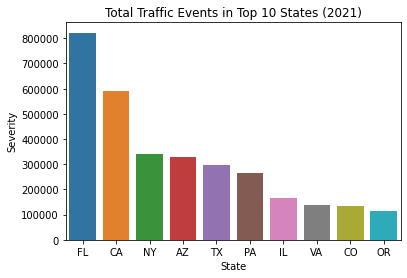

In [27]:
# Let's try  an overall count of the top ten states
topten = get_total_events_by_state(df_a, df_c, severity=False).sort_values(ascending=False)[:10]
sns.barplot(x=topten.index,y=topten).set(title="Total Traffic Events in Top 10 States (2021)")
plt.savefig(r"TotalTrafficEvents.png", bbox_inches='tight', transparent=False)

# fig.show()

# notes on saving a seaborn figure:
# swarm_plot = sns.swarmplot(...)
# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

The above looks correct for absolute values - big states lead the way. Also, LOL at Pennsylvania ranking just behind Texas for absolute counts. How does relative look?

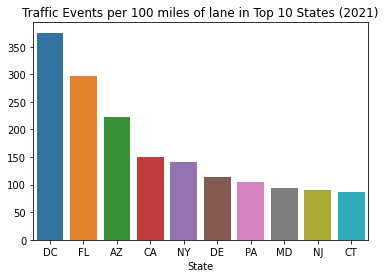

In [28]:
# Lets normalize these values now
topten_rel = df_rel.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Traffic Events per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"TotalTrafficEvents100.png", bbox_inches='tight', transparent=False)


Interesting! Some important notes:

1. This is just for 2021.
2. This is the number of events per 100 miles of LANE. So, your average two-way road counts for 2 lanes, so a 1 mile stretch of road is "2 miles of lane". This means that, generally, states which have more lanes (more 4 lane highways) will appear to have a smaller amount of accidents per 100 miles. I have decided NOT to adjust this, since I am trying to measure "unpleasantness of driving," and I think states deserve a reqard for having more lanes.

That being said, a big state like New York has about 75 events per year per 100 miles of two lane road. That... sounds reasonable, I think. Between fender benders and construction, I really think this sounds about right. This is almost CERTAINLY weighted heavily by more traveled roads, but I think this is a nice first swing.

Washington D.C. leads the way for most traffic incidents per 100 miles of lane! This alone seems to validate this methodology to me, as D.C. features some very difficult driving. Florida, California, and New York also make sense to me as ranking highly. I am a little surprised by Arizona's ranking, as its infrastructure is much newer than the other states listed here, but it's very populous. Interestingly, while Texas made the top ten list for overall events, it does NOT rank highly for events per 100 miles. The same is true for Illinois and Virginia, so I assume the size of these states normalizes for this. Texas is the second most populated state in the US, so I guess they deserve some credit for keeping traffic events down. 

Let's look at these rankings when we include SEVERITY. Instead of just counting events, this uses the Severity field, where construction or traffic is ranked from 1 to 4. Note - I have NOT been able to determine what exactly these rankings mean, but it seems a shame to not use this data, especially for such a thumb-in-the-wind analysis as this one.

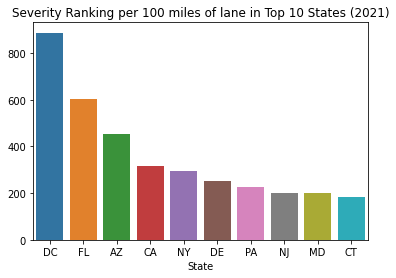

In [29]:
df_rel_sev = get_total_normalized_events_by_state(df_a, df_c, df_roadlengths, highways = "all", severity = True)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Severity Ranking per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"TotalSeverity100.png", bbox_inches='tight', transparent=False)

Interesting again! The rankings are almost completely unchanged, with only New Jerey and Maryland swapping positions. Let's produce a few plots now, looking at accidents and construction separately.

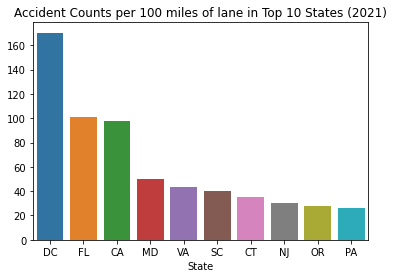

In [30]:
df_rel_sev = get_normalized_events_by_state(df_a, df_roadlengths, highways = "all", severity = False)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Accident Counts per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"Accidents100.png", bbox_inches='tight', transparent=False)

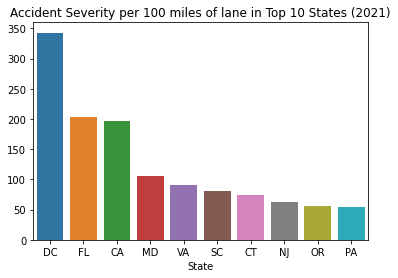

In [31]:
df_rel_sev = get_normalized_events_by_state(df_a, df_roadlengths, highways = "all", severity = True)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Accident Severity per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"AccidentsSeverity100.png", bbox_inches='tight', transparent=False)

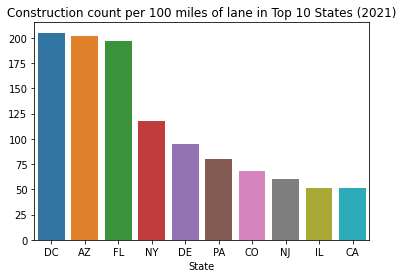

In [32]:
df_rel_sev = get_normalized_events_by_state(df_c, df_roadlengths, highways = "all", severity = False)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Construction count per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"Construction100.png", bbox_inches='tight', transparent=False)

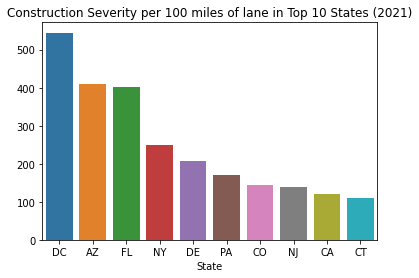

In [33]:
df_rel_sev = get_normalized_events_by_state(df_c, df_roadlengths, highways = "all", severity = True)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Construction Severity per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"ConstructionSeverity100.png", bbox_inches='tight', transparent=False)

At this point, I am not really seeing major differences ranking-wise between counts and severity. So, for the sake of the ease of interpretation, I will only discuss counts per 100 miles for events, and I will not consider their severity.

Washington D.C. takes the top spot for everything! This seems a little unfair, as a better comparison for DC would probably just be a major city like New York or LA. However, "DC is a terrible place to drive" rolls off the tongue pretty easily, so I will keep it there.

Some interesting observations, now that we have everything plotted:
- Arizona has a ton of construction, but does not hit the top 10 rankings for accidents per 100 miles. I think anyone who has driven in Arizona can believe this, as their infrastructure is relatively new compared to most states.
- Florida ranks highly for construction and accidents. Unsurprising.
- New York ranks high for construction, but not for accidents. This DOES surprise me, although it probably does not surprise New Yorkers, based on the egos of drivers I have met from there. I think New York City really warranta a city-based version of this analysis.
- Pennsylvania just makes the top 10 for accident occurences, and is 6th for construction. I have spent a lot of time driving across Pennsylvania, and I have to admit, I thought PA would have ranked worse here. I guess if you count PA as a big-time East-Coast state this is to be expected, but if you compare it to non-coastal neighbors like Ohio or West Virginia it feels pretty bad.
- Kudos to Texas, for ranking highly for TOTAL events but not making the top 10 for EITHER accidents or construction per 100 miles of lane.

Overall, I think this analysis actually has some merit, as it matches some of my pre-existing notions about driving in these states.

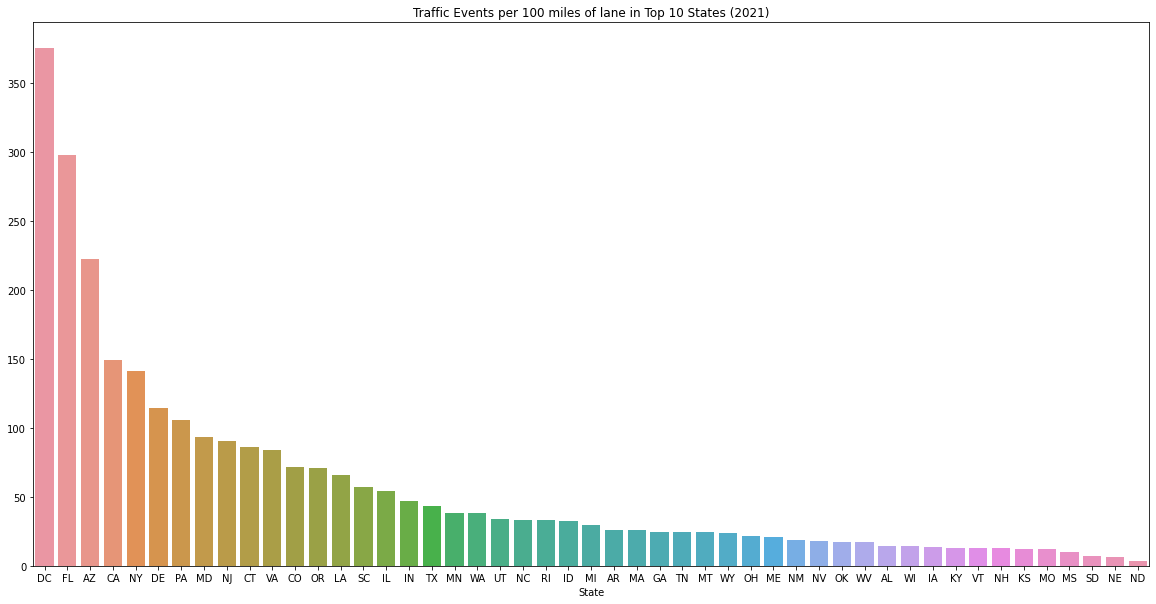

In [34]:
topten_rel = df_rel.sort_values(ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Traffic Events per 100 miles of lane in Top 10 States (2021)");
plt.savefig(r"TotalTrafficEvents100_bottom.png", bbox_inches='tight', transparent=False)

### 2. Is there a significant difference in highway vs non-highway traffic event occurrence? Do states which fair poorly in one category also fair poorly in the other?
### 3. Does accident frequency correlate to construction frequency?
### 4. Generally speaking, is there a correlation between the amount of funding a state receives and the amount of construction which occurs? Do accidents have any correlation with funding?

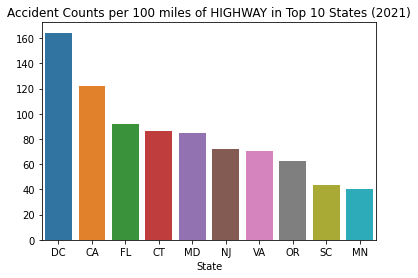

In [35]:
df_rel_sev = get_normalized_events_by_state(df_a, df_roadlengths, highways = "yes", severity = False)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Accident Counts per 100 miles of HIGHWAY in Top 10 States (2021)");
plt.savefig(r"AccidentsHighwaysCounts100.png", bbox_inches='tight', transparent=False)

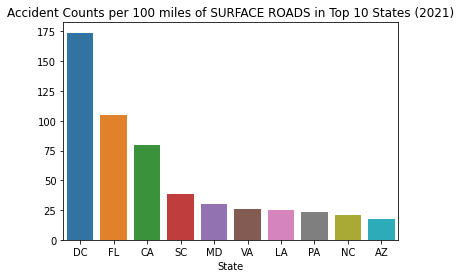

In [36]:
df_rel_sev = get_normalized_events_by_state(df_a, df_roadlengths, highways = "no", severity = False)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Accident Counts per 100 miles of SURFACE ROADS in Top 10 States (2021)");
plt.savefig(r"AccidentsSurfaceCounts100.png", bbox_inches='tight', transparent=False)

DC leads the way for accidents on and off the highway. After that, we see some interesting findings. South Carolina is bad for both, but ranks significantly worse for surface street accidents than for highway accidents. Conversely, New Jersey ranks poorly for highway accidents, but does NOT rank in the top 10 for surface street accidents. Again, some of my pre-existing biases are being confirmed here - who gets off the highway in Jersey? 

However, the top 10 for accidents are largely the same - Florida and California fare poorly, and Maryland and Virginia rank poorly as well. It would probably be useful to show the ranks for these side by side.

In [37]:
df_all_events_per_100 = get_total_normalized_events_by_state(df_a, df_c, df_roadlengths, highways = "all", severity = False)
df_acc_high = get_normalized_events_by_state(df_a, df_roadlengths, highways = "yes", severity = False)
df_acc_surf = get_normalized_events_by_state(df_a, df_roadlengths, highways = "no", severity = False)
df_con_high = get_normalized_events_by_state(df_c, df_roadlengths, highways = "yes", severity = False)
df_con_surf = get_normalized_events_by_state(df_c, df_roadlengths, highways = "no", severity = False)

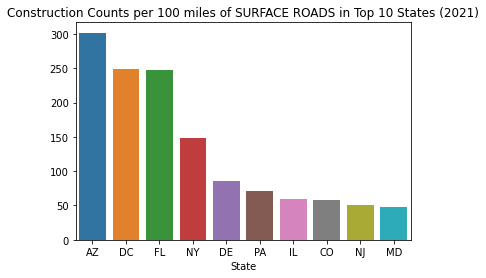

In [38]:
df_rel_sev = get_normalized_events_by_state(df_c, df_roadlengths, highways = "no", severity = False)
topten_rel = df_rel_sev.sort_values(ascending=False)[:10]
sns.barplot(x=topten_rel.index,y=topten_rel).set(title="Construction Counts per 100 miles of SURFACE ROADS in Top 10 States (2021)");
plt.savefig(r"ConstructionSrufaceCounts100.png", bbox_inches='tight', transparent=False)

In [39]:
df_summary = pd.DataFrame()
df_summary["TotalEvents"] = df_all_events_per_100
df_summary["AccidentsHighway"] = df_acc_high
df_summary["AccidentsRoad"] = df_acc_surf
df_summary["ConstructionHighway"] = df_con_high
df_summary["ConstructionRoad"] = df_con_surf

df_fund = df_funding[["StatePC", ' State Total']]
df_fund.columns = ["State","FederalFunding"]
df_fund = df_fund.set_index("State")
df_fund = df_fund.loc[df_summary.index]
df_summary["FederalFunding"] = df_fund["FederalFunding"]

df_summary.rank(ascending=False).sort_values("TotalEvents").to_markdown()

'| State   |   TotalEvents |   AccidentsHighway |   AccidentsRoad |   ConstructionHighway |   ConstructionRoad |   FederalFunding |\n|:--------|--------------:|-------------------:|----------------:|----------------------:|-------------------:|-----------------:|\n| DC      |             1 |                  1 |               1 |                     1 |                  2 |               15 |\n| FL      |             2 |                  3 |               2 |                     4 |                  3 |                9 |\n| AZ      |             3 |                 15 |              10 |                    30 |                  1 |               12 |\n| CA      |             4 |                  2 |               3 |                    11 |                 11 |                1 |\n| NY      |             5 |                 11 |              11 |                    10 |                  4 |                2 |\n| DE      |             6 |                 12 |              14 |         

Ranking the states is fun! Some more interesting observations:
- Arizona has a ton of surface street construction. If you have been to Arizona, this is not surprising.
- I personally find it interesting that Pennsylvania ranks so highly for highway construction at #3. This is NOT surprising, based on my driving experiences. While it is populous, it is not all that large, area-wise. Pennsylvania, why are you fixing your highways so often? [FIX YOUR BRIDGES](https://apnews.com/article/joe-biden-business-pittsburgh-bridge-collapses-b91476e4d1dc1c7839bd0c39e7be186e)!
- California, New York, and Illinois are the top 3 federal funding-receiving states. Definitely sounds related to major cities.
- The Dakotas and Nebraska are at the bottom of our rankings. This is not too surprising, and serves as another reality-check that there is some validity to this method of analysis.

In [40]:
print(df_summary.corr().to_markdown())

|                     |   TotalEvents |   AccidentsHighway |   AccidentsRoad |   ConstructionHighway |   ConstructionRoad |   FederalFunding |
|:--------------------|--------------:|-------------------:|----------------:|----------------------:|-------------------:|-----------------:|
| TotalEvents         |      1        |           0.802235 |        0.875641 |              0.721393 |           0.914098 |         0.345965 |
| AccidentsHighway    |      0.802235 |           1        |        0.835743 |              0.673939 |           0.535048 |         0.451244 |
| AccidentsRoad       |      0.875641 |           0.835743 |        1        |              0.597159 |           0.657964 |         0.329201 |
| ConstructionHighway |      0.721393 |           0.673939 |        0.597159 |              1        |           0.525718 |         0.247874 |
| ConstructionRoad    |      0.914098 |           0.535048 |        0.657964 |              0.525718 |           1        |         0.232226 |

The correlation matrix has some interesting findings for us.
- Highway accidents correlate very strongly to surface street accidents. One possible interpretation of this information is that accident frequency is regionally dependent, but NOT dependent on a specific roadway or type of road. Maybe local culture, laws, or driving habits contribute to this?
- Construction on highways vs surface streets are somewhat correlated. This sounds about right - certain states probably tend to spend more than others.
- Accidents and construction are MODERATELY correlated. I would have expected a stronger correlation, but some connection makes sense.
- Federal funding does not correlate very strongly to anything. There is SOME correlation to highway accidents (0.45), but this seems like grasping for straws. I don't think we can make any intelligent observations based on how funding relates to road events. I would have EXPECTED highway construction to correlate with Federal funding, especially on interstates. However, such is not the case.

### Summary, and some light conclusions

This analysis began with a not-very-scentific question - what are the least pleasant states for driving? Accident and construction data have been made readily available by Sobhan Moosavi and their research team, and this seemed like a great place to start trying to come up with a numeric answer to this question.

I call the following statements "light conclusions," since this is a very preliminary analysis which just averages event occurences across entire states. Still, I think it is an interesting first step at quantifying how likely a person is to get stuck in traffic from a "traffic event":

1. When we normalize for the amount of roads, which states exhibit the highest frequency of traffic events? The lowest?
    - Overall, Washington D.C. easily ranks higher than any US state for occurence of traffic events per 100 miles of road. Moving on to states, we see expected states appearing as the most likely to have traffic events: Florida, California, Arizona, New York, Delaware, and Pennslyvania rank highly. Arizona is an outlier here, as it leads the US for surface street construction but no other categories. 
    - Likewise, expected states with low populations feature low traffic events overall, including the Dakotas, Nebraska, Mississippi, and Missouri. 
2. Is there a significant difference in highway vs non-highway traffic event occurrence? Do states which fair poorly in one category also fair poorly in the other?
    - Overall, there is a correlation between highway vs non-highway events, but there are some interesting outliers:
        - As stated above, Arizona has a very large amount of non-highway construction occurring, but it ranks 30th for highway construction. This is very interesting, given the size of Arizona and the need for higways.
        - Conversely, Pennsylvania, a smaller state by area, ranks number 3 for highway construction. It also ranks 6 for road construction, however, so there is not a major difference here.
        - New Jersey and Connecticut both rank very highly for highway accidents, but do not make the top 10 for surface street accidents. My uneducated guess for New Jersey is that there is a large group of drivers from surrounding states passing through for work or to get to New York or Phildelphia. 
        - In general, states with lots of highway accidents also have lots of surface street accidents. This is less true for construction - there is only moderate correlation between highway and surface street construction. 
3. Does accident frequency correlate to construction frequency? Do these correlate in some states but not others?
    - There is SOME correlation between accidents of all kinds and construction of all kinds. As a long-distance driver, I have wondered about the relationship between road-blocking construction and accidents. If I were a government planner, I think there is ABSOLUTELY enough evidence of a correlation here to dig deeper and better understand this relationship - a correation of over 0.5 in a flippant analysis like this definitely indicates that there exists SOME relationship. 
4. Generally speaking, is there a correlation between the amount of funding a state receives and the amount of construction which occurs? Do accidents have any correlation with funding?
    - Overall, there is a poor relationship. When looking through the details of the funding data, I do not see anything that stands out as "road work funding," so it's maybe no surprise that we do not see a correlation here. However, the absence of a negative correlation with accidents may be telling - wouldn't we expect an inverse relationship between federal funding and accidents? That being said, the funding looks targeted at things like public transportation and emissions, so maybe this is not a surprise.
    - States with big cities rank highly - California, New York, and Illinois lead the way. This matches with my original thoughts, being that the funding is more closely aligned with urban-planning and managment activities.

This has been an entertaining exploration of these data. There were some surprises here, but the states which have lots of traffic events did not end up surpsing me all that much. If I wanted to spend more time here, I think the next step would definitely be to break this down into smaller regions, so we could account for major cities and surrounding rural areas. It would be great to get some "true" traffic information as well, but I think that is a tougher nut to crack. Here's to hoping that Pennsylvania gets those highways repaired!

- Rocco Panella, 2022 May 5